# Plant Disease Classification Using Deep Learning

This notebook demonstrates a complete workflow for classifying plant diseases using deep learning techniques. The process includes dataset preparation, model building, training, evaluation, and prediction. The dataset used is a large collection of plant leaf images with various diseases, sourced from Kaggle.

---

## 1. Download and Extract Dataset
The following cell downloads the plant disease dataset from Kaggle and extracts it for use in the project.

In [ ]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset --force

## 2. Extract Dataset
The following cell extracts the downloaded zip file into a directory. After extraction, the dataset will be available for further processing and analysis.

In [ ]:
import zipfile

with zipfile.ZipFile("new-plant-diseases-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("new_plant_diseases_dataset")

## 3. Import Required Libraries for Model Training

This cell imports additional libraries needed for data preprocessing, model building, and training. These include TensorFlow, Keras, and utility functions for handling images and callbacks.

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, image
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import BatchNormalization

## 4. Configure Data Generators and Hyperparameters

Set up the directories for training and validation data, define hyperparameters such as batch size and image size, and create data generators for preprocessing and augmenting the images. These generators will be used to feed data into the model during training and validation.

In [ ]:
# Directories for training and validation data
train_dir = "new_plant_diseases_dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
valid_dir = "new_plant_diseases_dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"
checkpoint_dir = '/kaggle/working/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Hyperparameters
num_classes = 38
batch_size = 16
# image_size = (299, 299)
image_size = (128, 128)
class_mode = "categorical"

# Image data generators for rescaling and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input
)

valid_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input
)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,  # Resizing images to 299x299
    batch_size=batch_size,
    class_mode=class_mode
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=image_size,  # Resizing images to 299x299
    batch_size=batch_size,
    class_mode=class_mode
)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


## 5. Save and Manage Model Checkpoints

To prevent loss of progress during training, model checkpoints are saved at regular intervals. This cell copies the checkpoint files to a designated directory for easy download and backup.

In [ ]:
import shutil

checkpoint_dir = '/kaggle/working/checkpoints'

destination_dir = '/kaggle/working/downloaded_checkpoints'

os.makedirs(destination_dir, exist_ok=True)

checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.endswith('.weights.h5')]

for file in checkpoint_files:
    shutil.copy(os.path.join(checkpoint_dir, file), destination_dir)

print(f"Files copied to {destination_dir}. You can now download them from the 'Output' tab.")

Files copied to /kaggle/working/downloaded_checkpoints. You can now download them from the 'Output' tab.


## 6. Build and Train a Convolutional Neural Network (CNN)

This section defines a custom CNN architecture for plant disease classification. The model includes convolutional, pooling, batch normalization, and dense layers. Training is performed with checkpointing and optional interactive epoch control.

In [ ]:
def create_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        BatchNormalization(), 
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(), 
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(), 
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(), 
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(512, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(38, activation='softmax')
    ])
    return model

model = create_cnn_model()
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_file = '/kaggle/working/checkpoint_dir_bn_2'


checkpoint_files = sorted([f for f in os.listdir(checkpoint_file) if f.endswith('.weights.h5')])
if checkpoint_files:
    latest_checkpoint = os.path.join(checkpoint_file, checkpoint_files[-1])
    print(f"Resuming training from {latest_checkpoint}")
    model.load_weights(latest_checkpoint)
else:
    print("No checkpoints found. Starting training from scratch.")

checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_file, 'model_epoch_{epoch:02d}.weights.h5'),
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1,
    save_weights_only=True 
)

def train_with_interactive_epochs():
    epochs = 50
    last_epoch_weights = model.get_weights() 
    last_epoch = 0
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        history = model.fit(
            train_generator,
            steps_per_epoch=train_generator.samples // train_generator.batch_size,
            epochs=1, 
            validation_data=valid_generator,
            validation_steps=valid_generator.samples // valid_generator.batch_size,
            callbacks=[checkpoint_callback],
            verbose=1
        )
        
        all_train_accuracy.append(history.history['accuracy'][0])
        all_val_accuracy.append(history.history['val_accuracy'][0])
        all_train_loss.append(history.history['loss'][0])
        all_val_loss.append(history.history['val_loss'][0])

    
        if (epoch + 1) % 2 == 0:
            user_input = input(f"Epoch {epoch + 1} completed. Do you want to continue training with new weights? (y/n): ").strip().lower()
            
            if user_input == 'n':
                print("Reverting to previous epoch weights.")
                model.set_weights(last_epoch_weights)
                print("Stopping training.")
                break
        
            

    print("Training completed.")

train_with_interactive_epochs()

No checkpoints found. Starting training from scratch.
Epoch 1/50
4392/4393 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5218 - loss: 1.7285
Epoch 1: val_loss improved from inf to 1.40520, saving model to /kaggle/working/checkpoint_dir_bn_2/model_epoch_01.weights.h5
4393/4393 ━━━━━━━━━━━━━━━━━━━━ 86s 18ms/step - accuracy: 0.5219 - loss: 1.7282 - val_accuracy: 0.6529 - val_loss: 1.4052
Epoch 2/50
4389/4393 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8723 - loss: 0.4165
Epoch 1: val_loss improved from 1.40520 to 0.31378, saving model to /kaggle/working/checkpoint_dir_bn_2/model_epoch_01.weights.h5
4393/4393 ━━━━━━━━━━━━━━━━━━━━ 80s 18ms/step - accuracy: 0.8724 - loss: 0.4165 - val_accuracy: 0.9060 - val_loss: 0.3138


Epoch 2 completed. Do you want to continue training with new weights? (y/n):  y


Epoch 3/50
4390/4393 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9292 - loss: 0.2330
Epoch 1: val_loss did not improve from 0.31378
4393/4393 ━━━━━━━━━━━━━━━━━━━━ 76s 17ms/step - accuracy: 0.9292 - loss: 0.2330 - val_accuracy: 0.8427 - val_loss: 0.5845
Epoch 4/50
4387/4393 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9493 - loss: 0.1748
Epoch 1: val_loss improved from 0.31378 to 0.24996, saving model to /kaggle/working/checkpoint_dir_bn_2/model_epoch_01.weights.h5
4393/4393 ━━━━━━━━━━━━━━━━━━━━ 79s 18ms/step - accuracy: 0.9493 - loss: 0.1748 - val_accuracy: 0.9347 - val_loss: 0.2500


Epoch 4 completed. Do you want to continue training with new weights? (y/n):  y


Epoch 5/50
4392/4393 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9620 - loss: 0.1363
Epoch 1: val_loss did not improve from 0.24996
4393/4393 ━━━━━━━━━━━━━━━━━━━━ 77s 18ms/step - accuracy: 0.9620 - loss: 0.1363 - val_accuracy: 0.9086 - val_loss: 0.3816
Epoch 6/50
4392/4393 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9648 - loss: 0.1215
Epoch 1: val_loss improved from 0.24996 to 0.21428, saving model to /kaggle/working/checkpoint_dir_bn_2/model_epoch_01.weights.h5
4393/4393 ━━━━━━━━━━━━━━━━━━━━ 79s 18ms/step - accuracy: 0.9648 - loss: 0.1215 - val_accuracy: 0.9444 - val_loss: 0.2143


Epoch 6 completed. Do you want to continue training with new weights? (y/n):  y


Epoch 7/50
4389/4393 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9744 - loss: 0.0944
Epoch 1: val_loss did not improve from 0.21428
4393/4393 ━━━━━━━━━━━━━━━━━━━━ 76s 17ms/step - accuracy: 0.9744 - loss: 0.0944 - val_accuracy: 0.9446 - val_loss: 0.2203
Epoch 8/50
4389/4393 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9766 - loss: 0.0913
Epoch 1: val_loss did not improve from 0.21428
4393/4393 ━━━━━━━━━━━━━━━━━━━━ 77s 17ms/step - accuracy: 0.9766 - loss: 0.0913 - val_accuracy: 0.9283 - val_loss: 0.2967


Epoch 8 completed. Do you want to continue training with new weights? (y/n):  y


Epoch 9/50
4388/4393 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9807 - loss: 0.0751
Epoch 1: val_loss did not improve from 0.21428
4393/4393 ━━━━━━━━━━━━━━━━━━━━ 77s 17ms/step - accuracy: 0.9807 - loss: 0.0751 - val_accuracy: 0.9509 - val_loss: 0.2178
Epoch 10/50
4390/4393 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9832 - loss: 0.0649
Epoch 1: val_loss did not improve from 0.21428
4393/4393 ━━━━━━━━━━━━━━━━━━━━ 79s 18ms/step - accuracy: 0.9832 - loss: 0.0649 - val_accuracy: 0.9359 - val_loss: 0.3202


Epoch 10 completed. Do you want to continue training with new weights? (y/n):  y


Epoch 11/50
4390/4393 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9849 - loss: 0.0619
Epoch 1: val_loss did not improve from 0.21428
4393/4393 ━━━━━━━━━━━━━━━━━━━━ 76s 17ms/step - accuracy: 0.9849 - loss: 0.0619 - val_accuracy: 0.7825 - val_loss: 1.9969
Epoch 12/50
4392/4393 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9819 - loss: 0.0810
Epoch 1: val_loss improved from 0.21428 to 0.17322, saving model to /kaggle/working/checkpoint_dir_bn_2/model_epoch_01.weights.h5
4393/4393 ━━━━━━━━━━━━━━━━━━━━ 80s 18ms/step - accuracy: 0.9819 - loss: 0.0810 - val_accuracy: 0.9630 - val_loss: 0.1732


Epoch 12 completed. Do you want to continue training with new weights? (y/n):  n


Reverting to previous epoch weights.
Stopping training.
Training completed.


## 7. Evaluate Model Performance

After training, evaluate the model's performance on both the training and validation datasets to measure accuracy and loss. This helps in understanding how well the model has learned and whether it is overfitting or underfitting.

In [35]:
# Evaluate the model on the training set (train accuracy)
train_loss, train_acc = model.evaluate(train_generator, steps=train_generator.samples // train_generator.batch_size, verbose=1)
print(f"Train Accuracy: {train_acc * 100:.2f}%")
print(f"Train Loss: {train_loss:.4f}")

# Evaluate the model on the validation set (validation accuracy and loss)
test_loss, test_acc = model.evaluate(valid_generator, steps=valid_generator.samples // valid_generator.batch_size, verbose=1)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

4393/4393 ━━━━━━━━━━━━━━━━━━━━ 62s 14ms/step - accuracy: 0.9898 - loss: 0.0359
Train Accuracy: 99.04%
Train Loss: 0.0380
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.9621 - loss: 0.1811
Test Accuracy: 96.29%
Test Loss: 0.1733


## 8. Save the Final Model

Once the model has been trained and evaluated, save the final model to disk for future inference or deployment.

In [ ]:
final_model_path = '/kaggle/working/final_model.h5'
model.save(final_model_path)

## 9. Load Model Weights for Further Evaluation

This cell demonstrates how to load model weights from a specific checkpoint for further evaluation or inference. This is useful if you want to resume from a particular epoch or analyze intermediate results.

In [ ]:
def create_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        BatchNormalization(),  
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),  
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),  
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),  
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(512, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(38, activation='softmax')  
    ])
    return model



model = create_cnn_model()
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


checkpoint_file = '/kaggle/working/checkpoint_dir_bn_2'
checkpoint_files = sorted([f for f in os.listdir(checkpoint_file) if f.endswith('.weights.h5')])
epoch_checkpoint = [f for f in checkpoint_files if 'model_epoch_01' in f]

if epoch_checkpoint:
    latest_checkpoint = os.path.join(checkpoint_file, epoch_checkpoint[0])
    print(f"Loading model weights from {latest_checkpoint}")
    model.load_weights(latest_checkpoint)
else:
    print("Epoch checkpoint not found. Please check your checkpoint directory.")

Loading model weights from /kaggle/working/checkpoint_dir_bn_2/model_epoch_01.weights.h5


## 10. Evaluate Model on Validation Set and Visualize Results

This section evaluates the trained model on the validation set, generates a confusion matrix, and provides a classification report. Visualization of the confusion matrix helps in understanding the model's performance across different classes.

Found 17572 images belonging to 38 classes.
True classes length: 17572
Predicted classes length: 17572
Confusion Matrix:
 [[464   1   4 ...   0   0   0]
 [  0 485   0 ...   0   0   0]
 [  0   0 410 ...   0   0   2]
 ...
 [  0   0   0 ... 481   0   0]
 [  0   0   0 ...   0 430   1]
 [  0   0   0 ...   0   0 479]]
Classification Report:
                                                     precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      0.92      0.96       504
                                 Apple___Black_rot       0.99      0.98      0.98       497
                          Apple___Cedar_apple_rust       0.99      0.93      0.96       440
                                   Apple___healthy       0.96      0.95      0.96       502
                               Blueberry___healthy       0.89      1.00      0.94       454
          Cherry_(including_sour)___Powdery_mildew       0.99      0.99      0.99       421
                 

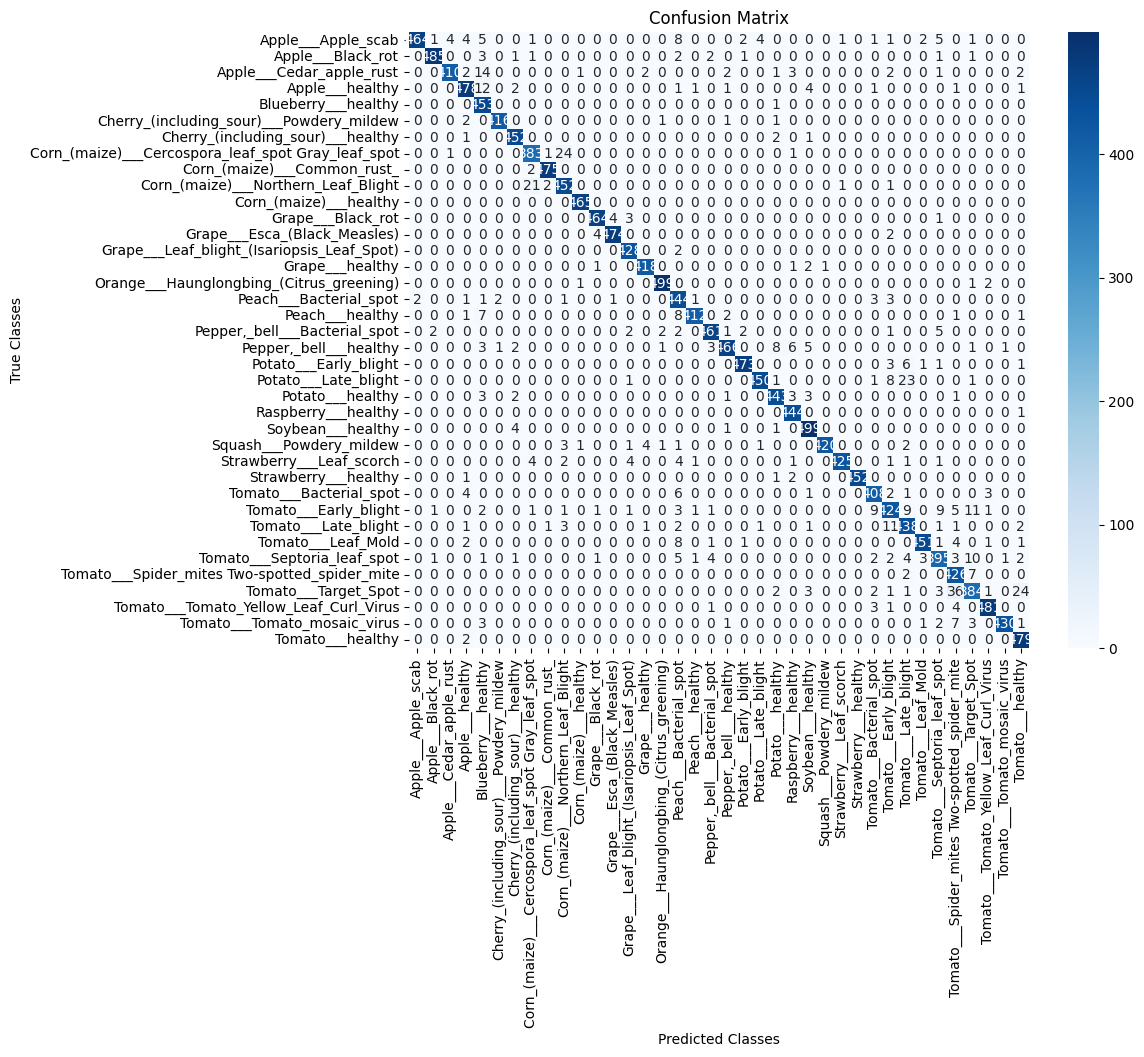

Accuracy: 96.30%


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image

model_path = '/kaggle/working/final_model.h5' 
model = tf.keras.models.load_model(model_path)

val_dataset_dir = "new_plant_diseases_dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"
class_names = sorted(os.listdir(val_dataset_dir))

from tensorflow.keras.preprocessing.image import ImageDataGenerator

val_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_generator = val_datagen.flow_from_directory(
    val_dataset_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False 
)

predicted_classes = []
true_classes = []

for batch_idx in range(len(val_generator)):
    batch_images, batch_labels = val_generator[batch_idx]
    batch_predictions = model.predict(batch_images, verbose=0)


    predicted_classes.extend(np.argmax(batch_predictions, axis=1))
    true_classes.extend(np.argmax(batch_labels, axis=1))

predicted_classes = np.array(predicted_classes)
true_classes = np.array(true_classes)

print(f"True classes length: {len(true_classes)}")
print(f"Predicted classes length: {len(predicted_classes)}")

conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:\n", conf_matrix)

class_report = classification_report(true_classes, predicted_classes, target_names=class_names)
print("Classification Report:\n", class_report)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)
print(f"Accuracy: {accuracy * 100:.2f}%")

## 11. Calculate Training and Validation Error Rates

This cell computes the error rates for both the training and validation datasets, providing additional insight into the model's performance and potential overfitting or underfitting.

In [ ]:
train_true_classes = []
train_predicted_classes = []

for batch_idx in range(len(train_generator)):
    batch_images, batch_labels = train_generator[batch_idx]
    batch_predictions = model.predict(batch_images, verbose=0)


    train_true_classes.extend(np.argmax(batch_labels, axis=1))
    train_predicted_classes.extend(np.argmax(batch_predictions, axis=1))

train_true_classes = np.array(train_true_classes)
train_predicted_classes = np.array(train_predicted_classes)

incorrect_train = np.sum(train_true_classes != train_predicted_classes)
total_train = len(train_true_classes)

train_error_rate = incorrect_train / total_train

print(f"Training Error: {train_error_rate * 100:.2f}%")



val_true_classes = []
val_predicted_classes = []

for batch_idx in range(len(valid_generator)):
    batch_images, batch_labels = valid_generator[batch_idx]
    batch_predictions = model.predict(batch_images, verbose=0)


    val_true_classes.extend(np.argmax(batch_labels, axis=1))
    val_predicted_classes.extend(np.argmax(batch_predictions, axis=1))

val_true_classes = np.array(val_true_classes)
val_predicted_classes = np.array(val_predicted_classes)

incorrect_val = np.sum(val_true_classes != val_predicted_classes)
total_val = len(val_true_classes)

val_error_rate = incorrect_val / total_val

print(f"Validation Error: {val_error_rate * 100:.2f}%")

Training Error: 2.67%
Validation Error: 5.21%


## 12. Print Correct and Incorrect Predictions

This cell prints the number of correct and incorrect predictions for both the training and validation datasets, offering a more detailed breakdown of the model's classification performance.

In [ ]:
train_true_classes = []
train_predicted_classes = []

for batch_idx in range(len(train_generator)):
    batch_images, batch_labels = train_generator[batch_idx]
    batch_predictions = model.predict(batch_images, verbose=0)


    train_true_classes.extend(np.argmax(batch_labels, axis=1))
    train_predicted_classes.extend(np.argmax(batch_predictions, axis=1))

train_true_classes = np.array(train_true_classes)
train_predicted_classes = np.array(train_predicted_classes)

correct_train = np.sum(train_true_classes == train_predicted_classes)
incorrect_train = len(train_true_classes) - correct_train

print(f"Training - Correct: {correct_train}, Incorrect: {incorrect_train}")


val_true_classes = []
val_predicted_classes = []

for batch_idx in range(len(valid_generator)):
    batch_images, batch_labels = valid_generator[batch_idx]
    batch_predictions = model.predict(batch_images, verbose=0)


    val_true_classes.extend(np.argmax(batch_labels, axis=1))
    val_predicted_classes.extend(np.argmax(batch_predictions, axis=1))

val_true_classes = np.array(val_true_classes)
val_predicted_classes = np.array(val_predicted_classes)

correct_val = np.sum(val_true_classes == val_predicted_classes)
incorrect_val = len(val_true_classes) - correct_val

print(f"Validation - Correct: {correct_val}, Incorrect: {incorrect_val}")

Training - Correct: 68421, Incorrect: 1874
Validation - Correct: 16657, Incorrect: 915


## 13. Predict Disease Class for a Single Image

This section demonstrates how to use the trained model to predict the disease class of a single plant leaf image. The image is preprocessed and passed through the model, and the predicted class is displayed.

In [ ]:
# Load the model
model_path = '/kaggle/working/final_model.h5' 
model = tf.keras.models.load_model(model_path)

# Path to the training dataset to retrieve class names
train_dir = "new_plant_diseases_dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
class_names = sorted(os.listdir(train_dir))

# Function to preprocess the image
def preprocess_image(img_path, target_size=(128, 128)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize the image
    return img_array

# Function to predict the class of an image
def predict_image(model, img_path):
    img_array = preprocess_image(img_path)
    predictions = model.predict(img_array)
    
    # Get the predicted class index
    predicted_class_idx = np.argmax(predictions, axis=1)
    
    # Get the predicted class name
    predicted_class_name = class_names[predicted_class_idx[0]]
    
    print(f"Predicted class name: {predicted_class_name}")
    return predicted_class_name

# Path to the test image
image_path = '/kaggle/working/new_plant_diseases_dataset/test/test/TomatoYellowCurlVirus2.JPG'

# Make prediction and print the class name
predicted_class = predict_image(model, image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
Predicted class name: Tomato___Tomato_Yellow_Leaf_Curl_Virus
